# MT Data-conditioned VAE

In [1]:
# pip install tensorflow

In [2]:
%load_ext autoreload
%autoreload 2

import os
import time
import gc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import scipy as sp
from scipy import interpolate
# import scipy.interpolate

from cgnn import cvae_mt64_updated as vae

In [3]:
run = 's4'
if not os.path.exists(run):
    os.makedirs(run)

# Set up survey

In [4]:
# remote reference frequencies
#   7.680002e+02   5.120000e+02   3.840000e+02   2.560000e+02   1.920000e+02   1.280000e+02
#   9.599997e+01   6.400000e+01   4.800001e+01   3.200000e+01   2.400000e+01   1.600000e+01
#   1.200000e+01   8.000000e+00   5.999999e+00   4.000000e+00   3.000000e+00   2.000000e+00
#   1.500000e+00   1.000000e+00   7.500002e-01   5.000000e-01   3.750000e-01   2.500000e-01
#   1.875000e-01


# mesh
# 64 ft
cell_size = 32*0.3048
depth_to_top = 32*0.3048
n_cells = 32
# one fewer depth; last cell extends to inf
#depths = depth_to_top + np.arange(1,n_cells)*cell_size
#depths to bottom
depths = np.array([4,8.4,13.24,18.56,24.42,30.86,37.95,45.74,54.31,63.74,74.11,85.52,98.07,111.88,127.07,143.78,162.16,182.38,204.62,229.08,255.99,285.59,318.15,353.97,393.37,436.71,484.38,536.82,594.5])
n_depths = len(depths)
print(n_depths)
# data frequencies
# conservative, lines up with remote referenced stations, minus one frequency to avoid extrapolation
f_a = np.logspace(-2, 9, num=12, base=2)
f_b = np.logspace(-4, 7, num=12, base=2)*3
times = np.array([0.013,0.039,0.065,0.104,0.169,0.273,0.443,0.703,1.094,1.693,2.63,4.102,6.406,9.961,16.055])*1e-3
# frequencies = np.logspace(-4, 10, 15, base=2)
nt = len(times)
print(nt)
# data are only real
ndata = nt

29
15


In [5]:
depths=np.append(depths,[554,573])
print(depths.shape)

(31,)


In [6]:
times = np.append(times,16.055*1e-3)
print(len(times))

16


In [7]:
# x = np.arange(depths.size)
# new_length = 63
# new_x = np.linspace(x.min(), x.max(), new_length)
# new_depths = sp.interpolate.interp1d(x, depths)(new_x)
# print(new_depths)
# print(len(new_depths))
# depths = new_depths

# Load training models and Create neural network

In [8]:
# normalize model parameters between -1 and 1
# remember, min resistivity is 0.01, max is 1e5
# Gaussian infill potentially allows for values outside this range, but not likely
min_model = np.log(1e-5)
max_model = np.log(1e5)
# pad by norm_pad, so that a bunch of values don't end up at -1
norm_pad = 0.1

# create network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times = times,
                   norm_pad=norm_pad,
                   data_std=0.1,
                   model_std=.01,
                   beta_vae=4,
                   model_loss_type='se',
                   data_loss_type='se'
                  )


thicknesses (31,)


c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [9]:
# Due to ranging orders of magnitude - recommended to keep
def preprocess(filename):
    '''
    Read RILD values from npy file
    Convert to log conductivity
    Reshape to include channel dimension
    '''
    x = np.log(np.load(filename))
    x = x.reshape(-1, n_cells, 1)
    return x

x_train_log = preprocess('Line1_Central_Conductivity.npy')
x_validate_log = preprocess('Line3_Central_Conductivity.npy')
x_test1_log = preprocess('Line2_Central_Conductivity.npy')
# x_test2_log = preprocess('KGS_RILD_64ft_test2.npy')
# print(x_train_log)

x_train_raw = np.load('Line1_Central_Observations.npy')
x_validate_raw = np.load('Line3_Central_Observations.npy')
x_test1_raw = np.load('Line2_Central_Observations.npy')
#print(x_train_raw_log)

# x_train_raw = network.model_to_tanhs(x_train_raw_log)
# x_validate_raw = network.model_to_tanhs(x_validate_raw_log)
# x_test1_raw = network.model_to_tanhs(x_test1_raw_log)
# print(x_train_raw)

x_train = network.model_to_tanhs(x_train_log)
x_validate = network.model_to_tanhs(x_validate_log)
x_test1 = network.model_to_tanhs(x_test1_log)
# x_test2 = network.model_to_tanhs(x_test2_log)
# print(x_train)
# print(np.max(x_train))

In [10]:
x_train1 = x_train[0:1000,]
x_validate1 = x_validate[0:1000,]
x_train_raw1 = x_train_raw[0:1000,]
x_validate_raw1 = x_validate_raw[0:1000,]
x_test_raw1 = x_test1_raw[0:1000,]
# plt.plot(x_train_raw1[0],np.append(0,depths))

In [11]:
# compute stds
model_std = np.std(x_train.flatten())
#mt_data_file = 'KGS_MT.npy'
#os.remove(mt_data_file)
#try:
#    all_data = tf.convert_to_tensor(np.load(mt_data_file))
#except FileNotFoundError:
#    all_data = network.predict_tanh(x_train)
#    np.save(mt_data_file, all_data.numpy())
train_data = x_train1[:,:,0]
print(train_data)
print("train data", train_data.shape)
print('.........')

raw_train_data = -x_train_raw1
# log_train_data = tf.math.log(-train_data)
#print('log_train_data'log_train_data.shape)
print("raw_train_data", raw_train_data.shape)
print(raw_train_data)
validate_data = x_validate1[:,:,0]
raw_validate_data = x_validate_raw1

# test1_data = network.predict_tanh(x_test1)
# log_test1_data = tf.math.log(-test1_data)

# test2_data = network.predict_tanh(x_test2)
# log_test2_data = tf.math.log(-test2_data)

[[-0.3717506  -0.35877268 -0.33019401 ... -0.5399025  -0.53984124
  -0.53986997]
 [-0.35924058 -0.3459848  -0.3168738  ... -0.53991749 -0.53985802
  -0.53988592]
 [-0.34984667 -0.33582953 -0.30524038 ... -0.53992124 -0.53986095
  -0.53988923]
 ...
 [-0.17945237 -0.15864629 -0.12139163 ... -0.53989797 -0.53986838
  -0.53988226]
 [-0.17917573 -0.1583147  -0.12093393 ... -0.5398954  -0.53986531
  -0.53987942]
 [-0.17774358 -0.15715603 -0.12023772 ... -0.53989532 -0.53986605
  -0.53987978]]
train data (1000, 32)
.........
raw_train_data (1000, 16)
[[-7.947291 -7.020374 -6.58563  ... -0.582863 -0.272842 -0.272842]
 [-7.903422 -6.97731  -6.545748 ... -0.579572 -0.271219 -0.271219]
 [-7.858701 -6.934481 -6.506257 ... -0.576283 -0.269532 -0.269532]
 ...
 [-8.692881 -7.881269 -7.458712 ... -0.610495 -0.270002 -0.270002]
 [-8.713656 -7.898522 -7.477573 ... -0.616137 -0.273557 -0.273557]
 [-8.745406 -7.926272 -7.506173 ... -0.622007 -0.277042 -0.277042]]


In [12]:
# plt.plot(train_data[0],np.append(0,depths))
# plt.plot(obs1_new[0], np.append(0,depths), color='red')

In [13]:
# np.save('train_data.npy',train_data)
# np.save('raw_train_data.npy',raw_train_data)
# np.save('validate_data.npy',validate_data)
# np.save('raw_validate_data.npy',raw_validate_data)

In [14]:
# train_data = np.load('train_data.npy')
# raw_train_data = np.load('raw_train_data.npy')
# validate_data = np.load('validate_data.npy')
# raw_validate_data = np.load('raw_validate_data.npy')
print(train_data.shape)
print(raw_train_data.shape)

# plt.plot(x_train1[0],np.append(0,depths))
# plt.plot(train_data[0],np.append(0,depths))

(1000, 32)
(1000, 16)


In [15]:
# # Create batches and shuffle
BATCH_SIZE = 10

#x_train1 = models *log transform models*; log_train_data: raw data

train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(train_data, tf.float32), 
    tf.cast(raw_train_data, tf.float32))).shuffle(10000).batch(BATCH_SIZE)

validate_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(validate_data, tf.float32),
    tf.cast(raw_validate_data, tf.float32))).shuffle(10000).batch(x_validate1.shape[0])

# though the data vary over several orders of magnitude, 
# they don't vary so much within one frequency.
# data_std_vec = np.std(train_data.numpy(), axis=0)
# log_data_std_vec = np.std(log_train_data.numpy(), axis=0)
# log_data_std = np.std(log_train_data.numpy().flatten())
# average_log_data_std = np.std((log_train_data.numpy() - log_train_data.numpy().mean(axis=0)).flatten())
# print(model_std, log_data_std, average_log_data_std)
# compute elementwise stds
model_std_vec = np.std(x_train1, axis=0)
model_std_vec = np.reshape(model_std_vec, (n_cells))
# # compute relative std
mean_train_data = np.mean(train_data, axis=0)
rel_data_std = np.abs(mean_train_data)

# same for model, but mean over all
mean_model_value = np.mean(x_train1)
rel_model_std = 0.5*mean_model_value
# print(mean_model_value, rel_model_std)
# print(rel_data_std, model_std_vec)

In [16]:
# plt.plot(train_dataset[0],np.append(0,depths))

In [17]:
# finalize network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times=times,
                   norm_pad=norm_pad,
                   data_std=rel_data_std.reshape(1, -1, 1),
#                    model_std=model_std,
                   model_std=model_std_vec.reshape(1, -1, 1),
                   latent_dim=20,
                   beta_vae=1,
                   model_loss_type='se',
                   data_loss_type='se'
                  )

# double check forward model
'''

all_data[0, 0], all_data[0, 24]

network.predict_tanh(x_train[0:1])

c60 = np.load('KSG_RILD_60ft.npy')
c60[0].shape

vae.forward_1_freq(c60[200], depths, frequencies[0])[0]

vae.forward_1_freq(c60[200], depths, frequencies[-1])[0]

all_data.numpy().max(), all_data.numpy().min()

all_data.shape

'''

#for i_freq in range(nf):
#    plt.hist(all_data.numpy()[:, i_freq].flatten(), bins=50)

thicknesses (31,)


"\n\nall_data[0, 0], all_data[0, 24]\n\nnetwork.predict_tanh(x_train[0:1])\n\nc60 = np.load('KSG_RILD_60ft.npy')\nc60[0].shape\n\nvae.forward_1_freq(c60[200], depths, frequencies[0])[0]\n\nvae.forward_1_freq(c60[200], depths, frequencies[-1])[0]\n\nall_data.numpy().max(), all_data.numpy().min()\n\nall_data.shape\n\n"

In [18]:
# May be able to remove/adjust steps since I have data instead of models
i_random_train = np.arange(16)
# random_train = x_train[i_random_train].reshape((16, n_cells))
# pick some random training models
# i_random_train = np.random.randint(0, x_train1.shape[0], 16)
#i_random_train = np.arange(16)
random_train = x_train1[i_random_train].reshape((16, 32))
# print('i_random_train',i_random_train)
# print('random_train',random_train)
print(network.predict_tanh(random_train))
# predict their data
# print(n_cells)
random_data = network.predict_tanh(random_train.reshape(16, 32, 1))
# print('n_cells',n_cells)
random_log_data = tf.math.log(-random_data)
# print('random_log_data', random_log_data)
print('random_data',random_data)
# Save data and latent space inputs for plots
# print(network.latent_dim)
latent_input = tf.random.normal([16, network.latent_dim], seed=0, dtype=tf.float32)
# print(latent_input)
# print('n_data',network.n_data)
random_data1 = random_data[:,:16]
data_input = tf.reshape(random_data1,(16,network.n_time))
print('data_input',data_input)
zd_input = tf.concat((latent_input,data_input),axis=-1)
print('zd_input',zd_input)
# Why are there nan values????? The forward modelling produces (16,30) arrays which should fit perfectly into data_input
#

nb 16
ys_test (16,)
tf.Tensor(
[[6.4519066e+04 1.9955688e+04 1.2270044e+04 8.1872607e+03 5.6150542e+03
  3.9858987e+03 2.8229941e+03 1.9504941e+03 1.2835330e+03 8.1276251e+02
  5.1462402e+02 3.1746582e+02 1.7384924e+02 8.0267616e+01 2.7871250e+01
  2.7871250e+01 7.6798182e+00 6.8005896e+00 6.3997989e+00 6.0137305e+00
  5.5784969e+00 5.0915685e+00 4.5254316e+00 3.9174652e+00 3.3004906e+00
  2.6926312e+00 2.0921586e+00 1.4986231e+00 9.5409209e-01 5.2894050e-01
  2.3364827e-01 2.3364827e-01]
 [6.6047453e+04 2.0472447e+04 1.2529502e+04 8.3382705e+03 5.7135264e+03
  4.0563198e+03 2.8730571e+03 1.9852274e+03 1.3070612e+03 8.2831738e+02
  5.2460175e+02 3.2331793e+02 1.7674065e+02 8.1432983e+01 2.8210253e+01
  2.8210253e+01 7.8255129e+00 6.9227066e+00 6.5125208e+00 6.1188779e+00
  5.6758785e+00 5.1803918e+00 4.6042213e+00 3.9854660e+00 3.3573694e+00
  2.7381208e+00 2.1260283e+00 1.5212091e+00 9.6709406e-01 5.3529012e-01
  2.3602608e-01 2.3602608e-01]
 [6.6489188e+04 2.0858996e+04 1.2763265e+04

In [19]:
# plot a few random training models and their data
# vae.plot_complex(random_data, times=times, save2file=True, filename=run+'/training_MT_data.png')
vae.plot_logs(np.exp(network.tanhs_to_model(random_train)), depths=depths, save2file=True, 
              filename=run + '/training_models.png')

# Save starting plots
network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                    latent=zd_input,step=0)
# network.plot_data(save2file=True,folder=run,latent=zd_input,step=0)
# network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=0)

plt.close('all')
plt.clf()
gc.collect()

latent (16, 36)
tanhs (16, 32, 1)
tanhs (16, 32, 1)


43168

<Figure size 640x480 with 0 Axes>

In [20]:
optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

# Train

In [21]:
epochs = 10

In [24]:
validate_terms = []
train_terms = []
train_losses = []
ttest_losses = []
# print(len(train_dataset))
for epoch in range(1, epochs + 1):
    start_time = time.time()
#     print(train_dataset)
#     print(optimizer)
    for train_x in train_dataset:#.batch(BATCH_SIZE):
        # print(train_x)
        train_loss, train_term = vae.compute_apply_gradients(network, train_x, optimizer, 
                                    use_data_misfit=False)
        #train_losses.append(train_loss.numpy())
        train_terms.append([tt.numpy() for tt in train_term])
#         for test_x in test_dataset:
#             ttest_loss = vae.compute_losses(network, test_x)
#             terms = [loss(l).numpy() for l in ttest_loss]
#             ttest_losses.append(terms)
    end_time = time.time()

    # # compute and save losses
    for val_x in validate_dataset:#.batch(BATCH_SIZE):
        val_loss, val_term = vae.compute_loss(network, val_x)
        #terms = [tf.reduce_mean(l).numpy() for l in losses]
        #loss(vae.compute_reconstruction_loss(network, test_x))
    #elbo = -loss.result()
    validate_terms.append([tt.numpy() for tt in val_term])
    print('Epoch: {}, Data misfit: {:.4}, '
          'Reconstruction: {:.4}, '
          'KL: {:.4}, '
          'Elapsed {:.4} s'.format(epoch, val_term[0], val_term[1], val_term[2],
                                #elbo,
                                end_time - start_time))
        
    if epoch % 1e3 == 0:
        network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                 latent=zd_input,step=epoch)
        network.plot_data(save2file=True,folder=run,latent=zd_input,step=epoch)
        network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=epoch)
        plt.close('all')
        gc.collect()

network.inference_net.save(run+'/encoder.h5')
network.generative_net.save(run+'/decoder.h5')
#np.save(run+'/optimizer_weights.npy', optimizer.load_weights())
np.save(run+'/losses.npy', np.array(validate_terms))
np.save(run+'/train_losses.npy', np.array(train_terms))


reconstrauction
x Tensor("xy:0", shape=(10, 32), dtype=float32)
d_input Tensor("xy_1:0", shape=(10, 16), dtype=float32)
Tensor("add:0", shape=(10, 20), dtype=float32)
tanhs (10, 32, 1)
loss Tensor("StatefulPartitionedCall:0", shape=(), dtype=float32)
[<tf.Variable 'conv1d_3/kernel:0' shape=(3, 1, 8) dtype=float32>, <tf.Variable 'conv1d_3/bias:0' shape=(8,) dtype=float32>, <tf.Variable 'conv1d_4/kernel:0' shape=(3, 8, 16) dtype=float32>, <tf.Variable 'conv1d_4/bias:0' shape=(16,) dtype=float32>, <tf.Variable 'conv1d_5/kernel:0' shape=(3, 16, 32) dtype=float32>, <tf.Variable 'conv1d_5/bias:0' shape=(32,) dtype=float32>, <tf.Variable 'dense_2/kernel:0' shape=(96, 40) dtype=float32>, <tf.Variable 'dense_2/bias:0' shape=(40,) dtype=float32>, <tf.Variable 'dense_3/kernel:0' shape=(36, 64) dtype=float32>, <tf.Variable 'dense_3/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'conv1d_transpose_5/kernel:0' shape=(3, 32, 32) dtype=float32>, <tf.Variable 'conv1d_transpose_5/bias:0' shape=(32,) dt

KeyboardInterrupt: 

In [ ]:
network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
         latent=zd_input,step=epoch)

latent (16, 36)
tanhs (16, 32, 1)
tanhs (16, 32, 1)


In [655]:
network.plot_data(save2file=True,folder=run,latent=zd_input,step=epoch)

nb 16


In [ ]:
# something weird here
network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=epoch,weighted=False)

nb 16


In [666]:
plt.close('all')
plt.clf()
gc.collect()

22976

<Figure size 640x480 with 0 Axes>

# Load networks

In [667]:
network.inference_net = tf.keras.models.load_model(run+'/encoder.h5')
network.generative_net = tf.keras.models.load_model(run+'/decoder.h5')

In [668]:
loss_terms = np.load(run+'/losses.npy')

In [669]:
#optimizer_weights = np.load(run+'/optimizer_weights.npy', allow_pickle=True)

https://stackoverflow.com/questions/49503748/save-and-load-model-optimizer-state to train more

# Plot loss over epochs

In [670]:
plt.rcParams.update({'font.size': 18})

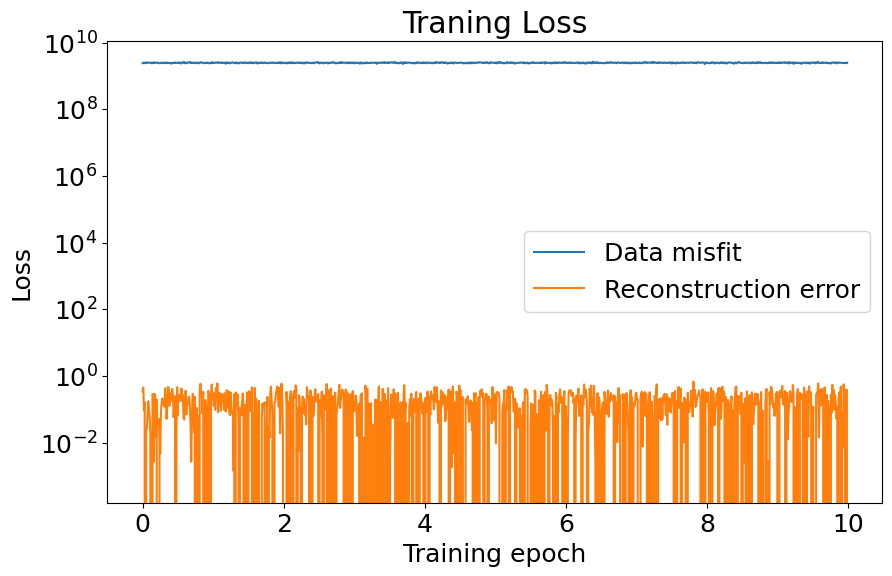

In [ ]:
tt = np.array(train_terms)
batches_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_batches = tt.shape[0]
plt.figure(figsize=(10,6))
plt.semilogy(np.arange(num_batches)/batches_per_epoch, tt)
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.title("Traning Loss")
plt.legend(['Data misfit', 'Reconstruction error', 'KL divergence'])
plt.savefig('training_loss_'+run+'_w.png')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

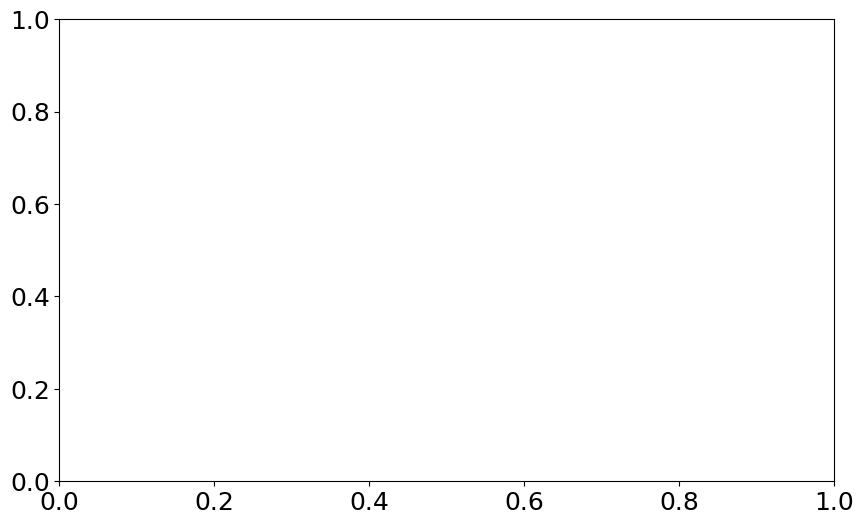

In [682]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(epochs),validate_terms)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.title('Validation Loss')
plt.legend(['Data misfit', 'Reconstruction error', 'KL divergence'])
plt.savefig('validation_loss_'+run+'_w.png')
plt.show()

# View some tests

In [45]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_validate[0:16])), depths=depths, step=16, save2file=True)

In [683]:
z_model = network.reparameterize(*network.encode(x_validate[0:16]))
z_data = raw_validate_data[0:16]
zmd = tf.concat((z_model,z_data),-1)
print(zmd)
network.plot_models(latent=zmd)

tf.Tensor(
[[-1.05344212e+00  1.05073452e+00  2.19512537e-01 -1.80833745e+00
   2.18261480e-01  1.61886787e+00  1.74826598e+00 -3.78356636e-01
   7.61471391e-01  5.74843407e-01 -1.15477741e+00  1.12437785e+00
   5.74872017e-01 -9.92219627e-01 -1.08247089e+00 -1.00060809e+00
   3.20130289e-01 -7.87490964e-01 -1.25426745e+00  2.89887786e-01
   6.52184916e+00  6.13078690e+00  5.86404324e+00  5.61342096e+00
   5.31803894e+00  4.96166420e+00  4.54561186e+00  4.09283495e+00
   3.60411310e+00  3.08018899e+00  2.51937890e+00  1.93574595e+00
   1.36348701e+00  8.40039015e-01  3.43571991e-01  3.43571991e-01]
 [-6.74754381e-01  9.91235077e-01 -2.60770738e-01 -1.57550704e+00
   1.40231848e-02  1.96166074e+00 -1.44413114e-01 -2.89955884e-01
   8.98319542e-01 -2.44599208e-01  3.72649968e-01  6.48778319e-01
   7.07732916e-01  5.11343181e-01  1.51266575e+00 -1.15321808e-01
  -3.49137872e-01 -9.62295294e-01 -1.02067018e+00 -1.02277994e+00
   6.48123121e+00  6.09415579e+00  5.83081198e+00  5.58007717e+0

In [684]:
def minmax(x): return tf.reduce_min(x), tf.reduce_max(x)

In [685]:
tanhs = network.decode(zmd, apply_tanh=True)
minmax(tanhs)

(<tf.Tensor: shape=(), dtype=float32, numpy=-0.67516756>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6150118>)

In [686]:
minmax(x_test1[0:16])

(<tf.Tensor: shape=(), dtype=float64, numpy=-0.5399266299885006>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.03254183984457575>)

In [ ]:
network.plot_data(latent=zmd)

nb 16


c:\Users\saraf\OneDrive\Documents\EM-CVAE-Graduate_Research\cgnn\cvae_mt64_updated.py:593: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.ylim(*ylims)


nb 16


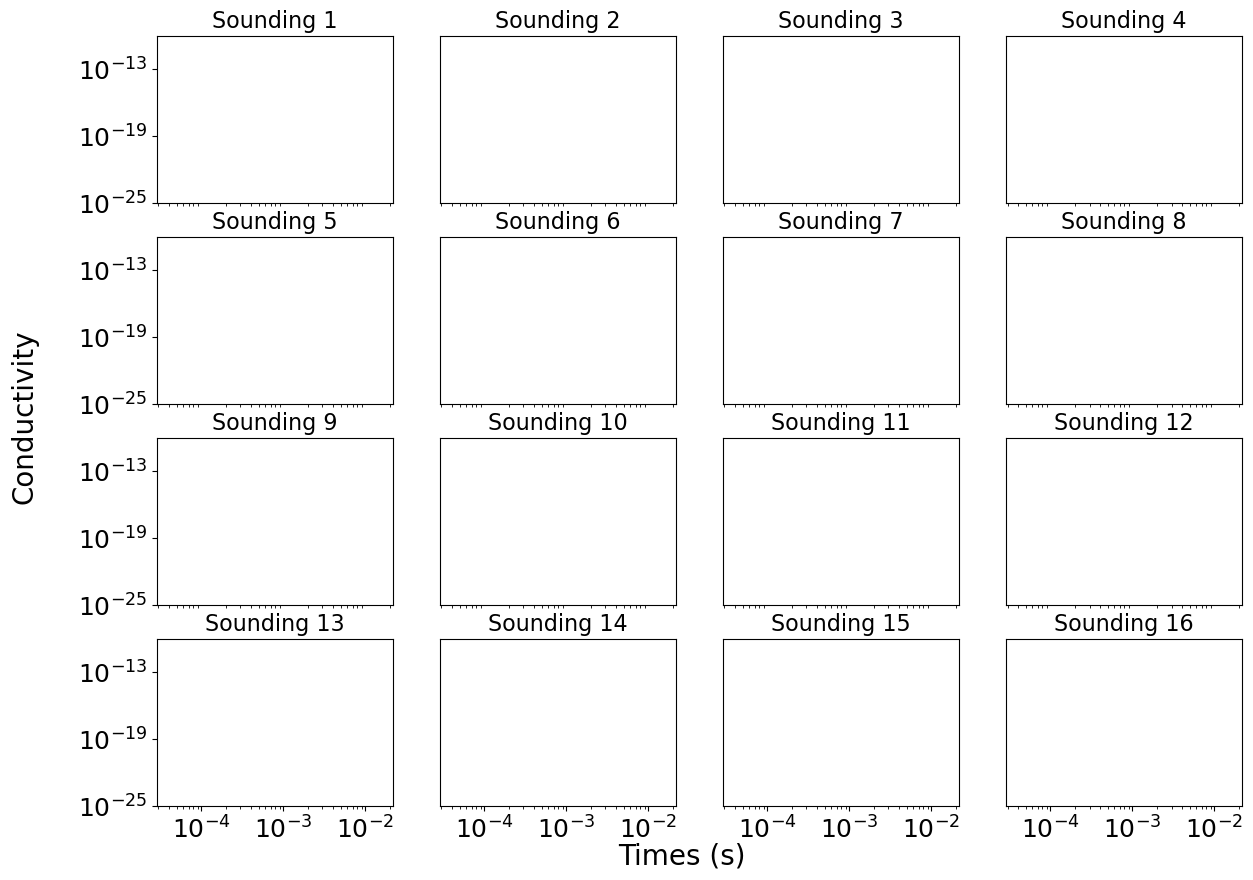

In [688]:
network.plot_residuals(latent=zmd, weighted=False)

# Randomize latent; does data still fit?

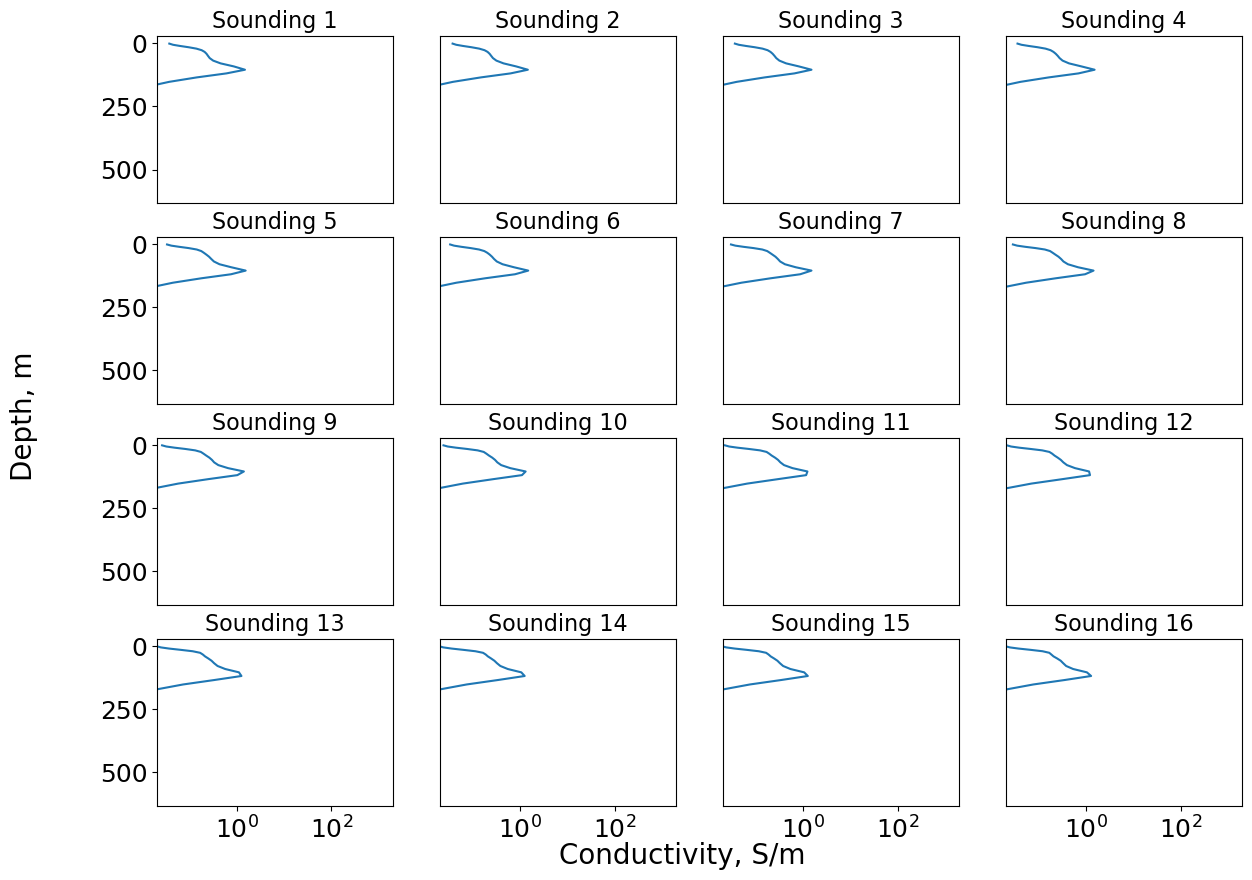

In [689]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_test1[0:16])), depths=depths)

In [690]:
print(x_test1[0:1].shape)

(1, 32, 1)


In [ ]:
data0 = tf.tile(z_data[0:1],[16,1])
print(latent_input)
data0 = tf.cast(data0, tf.float32)
print(data0)
zmd2 = tf.concat((latent_input,data0),-1)

tf.Tensor(
[[-3.1957254e-02  5.0398946e-01  9.5923221e-01 -3.2507833e-02
   1.5065966e+00  3.2107535e-01 -5.5792338e-01  8.2707316e-01
   1.3353117e-01  6.8636423e-01  6.1589110e-01 -7.7107400e-01
  -1.0550905e+00  7.8971422e-01  1.3649174e+00 -2.7857035e-01
   4.5750612e-01 -9.7834438e-02 -1.8102298e+00  6.7054617e-01]
 [ 2.0136318e+00  2.9394203e-01  1.3714147e+00 -5.6893611e-01
  -9.7091413e-01  1.6429951e+00  4.9178115e-01  7.2601986e-01
  -2.0039837e+00 -8.8503283e-01 -5.2633005e-01  6.0014790e-01
   6.4459026e-01  2.7135882e-01  1.0136005e+00  3.9845865e-02
  -6.5097260e-01 -1.9426189e-01  1.0948638e+00  7.2882640e-01]
 [ 3.6030959e-02  3.2482877e-01  7.0630088e-02  1.0102395e+00
  -1.1398194e+00 -8.3263779e-01  9.6327972e-01 -4.0186793e-01
  -1.1060729e+00  1.3777317e+00  6.6476452e-01 -5.7453785e-02
   2.6968747e-01 -2.0745331e-01  2.9835322e-01 -1.0460060e+00
   3.5465968e-01  1.8635759e+00  1.0787493e+00 -1.5552445e-01]
 [-1.1967753e+00 -1.6646914e-01  1.4709781e+00 -1.066568

In [ ]:
network.plot_models(latent=zmd2)

(16, 36)
(16, 32, 1)


In [693]:
zmd2_tanhs = network.decode(zmd2, apply_tanh=True)
zmd2_samples = zmd2_tanhs.shape[0]
zmd2_tanhs = np.reshape(zmd2_tanhs, (zmd2_samples, network.n_model))
zmd2_logs = np.exp(network.tanhs_to_model(zmd2_tanhs))

In [694]:
zmd2_logs.shape

(16, 32)

In [695]:
depth_centers = (network.depths[1:] + network.depths[:-1])/2
plot_depths = np.r_[
    depth_centers[0] - (depth_centers[1] - depth_centers[0]),
    depth_centers,
    depth_centers[-1] + depth_centers[-1] - depth_centers[-2]
]

In [696]:
# print(zmd2_logs)
mean_cond = np.mean((zmd2_logs),axis=0)
std_cond = np.std((zmd2_logs),axis=0)
uncertainty = np.mean(mean_cond+std_cond**2)
print(uncertainty)
# plt.semilogx(mean_cond, plot_depths)
# plt.invert_yaxis()

118587.695


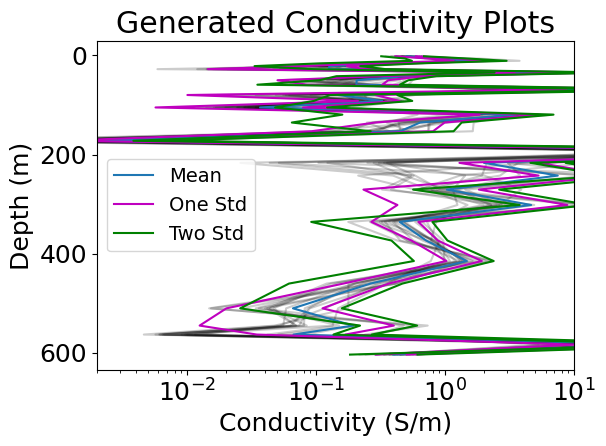

In [ ]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    ax.semilogx(log, plot_depths, c='k', alpha=0.2)
ax.semilogx(mean_cond, plot_depths,label='Mean')
ax.semilogx(np.abs(mean_cond+std_cond),plot_depths, c='m', label="One Std")
ax.semilogx(np.abs(mean_cond-std_cond), plot_depths, c='m')
ax.semilogx(np.abs(mean_cond+2*std_cond), plot_depths, c='g', label= 'Two Std') # type: ignore
ax.semilogx(np.abs(mean_cond-2*std_cond), plot_depths, c='g')
# ax.semilogx(mean_cond+std_cond**2, plot_depths)
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
ax.axes.set_xlim(2e-3, 1e1)
ax.axes.set_title('Generated Conductivity Plots')
ax.axes.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Preliminary_generated_plots_mean&2std.jpg')
plt.show()

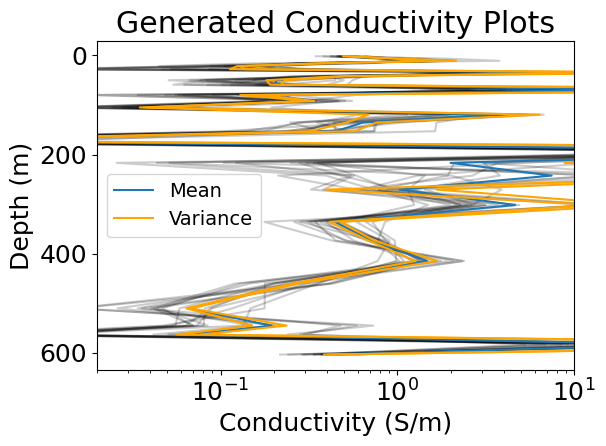

In [ ]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    ax.semilogx(log, plot_depths, c='k', alpha=0.2)
ax.semilogx(mean_cond, plot_depths,label='Mean')
ax.semilogx(np.abs(mean_cond+std_cond**2), plot_depths, c='orange', label='Variance')
ax.semilogx(np.abs(mean_cond-std_cond**2), plot_depths, c='orange')
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
ax.axes.set_xlim(2e-2, 1e1)
ax.axes.set_title('Generated Conductivity Plots')
ax.axes.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Preliminary_generated_plots.jpg')
plt.show()

In [ ]:
network.plot_data(latent=zmd2)

nb 16


c:\Users\saraf\OneDrive\Documents\EM-CVAE-Graduate_Research\cgnn\cvae_mt64_updated.py:593: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.ylim(*ylims)


In [700]:
#log_data_test[0]

In [701]:
-tf.exp(zmd2[0, 50:])

<tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>

In [702]:
# network.predict_tanh(network.decode(zmd2, apply_tanh=True))[0]

In [705]:
network.plot_residuals(latent=zmd2, weighted=True)

nb 16


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [16,16] vs. [1,32] [Op:Mul] name: 

In [706]:
y_true = [[0., 0.], 
          [0., 0.]]
y_pred = [[3., 0.], 
          [2., 0.]]
# Using 'auto'/'sum_over_batch_size' reduction type.
# Using 'none' reduction type.
mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.NONE)
# Calling with 'sample_weight'.
mse(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()


array([3.1499999, 0.6      ], dtype=float32)

In [707]:
1/2*((3-0)**2 + 0**2)*.7, 1/2*((2-0)**2 + (0-0)**2)*.3

(3.15, 0.6)

In [708]:
network.data_weights

array([[[5.48595234e+02],
        [6.64350638e+02],
        [1.01762084e+03],
        [2.13942172e+03],
        [6.29904544e+03],
        [1.73081025e+04],
        [1.88571551e+04],
        [1.25243956e+04],
        [1.16432945e+04],
        [2.35853466e+04],
        [3.57238109e+05],
        [1.90076739e+06],
        [1.22610847e+04],
        [1.76403655e+03],
        [6.37863586e+02],
        [3.46907159e+02],
        [2.34253210e+02],
        [1.80179363e+02],
        [1.50882595e+02],
        [1.33918997e+02],
        [1.23786746e+02],
        [1.17700540e+02],
        [1.14096509e+02],
        [1.12024355e+02],
        [1.10881603e+02],
        [1.10282769e+02],
        [1.09986440e+02],
        [1.09848638e+02],
        [1.09789471e+02],
        [1.09770243e+02],
        [1.09783744e+02],
        [1.09777411e+02]]])

In [709]:
print(cond2[0])
print(cond2[1])

[3.648398e-02 4.375333e-02 6.125686e-02 9.333318e-02 1.370639e-01
 1.768252e-01 2.043877e-01 2.243076e-01 2.409013e-01 2.620672e-01
 3.102367e-01 4.454715e-01 8.480549e-01 1.465697e+00 5.938051e-01
 1.385875e-01 3.616845e-02 1.220992e-02 5.347820e-03 2.938946e-03
 1.941052e-03 1.475557e-03 1.242081e-03 1.121129e-03 1.058532e-03
 1.026996e-03 1.011817e-03 1.004928e-03 1.002029e-03 1.001002e-03]
[3.692505e-02 4.404815e-02 6.117529e-02 9.257349e-02 1.356392e-01
 1.754015e-01 2.036590e-01 2.246761e-01 2.426639e-01 2.649555e-01
 3.129994e-01 4.433329e-01 8.184385e-01 1.454583e+00 6.258761e-01
 1.456389e-01 3.750132e-02 1.251276e-02 5.433118e-03 2.967756e-03
 1.952150e-03 1.480173e-03 1.244037e-03 1.121919e-03 1.058802e-03
 1.027046e-03 1.011785e-03 1.004876e-03 1.001975e-03 1.000939e-03]


In [710]:
# num_plots = 4
# fig = plt.figure(figsize=(8, 10))
# for i in range(0, num_plots):
#     ax = plt.subplot(int(num_plots),2,i+1)
#     ax.plot(times, -obs2[i], -pred2[i])
#     plt.xlabel('Time (s)')
#     plt.ylabel('dB/dt')
#     plt.legend(['Observed','Predicted'])
# plt.tight_layout()
# plt.savefig('Raw_Time_Decay_Curves_Line2_Central.jpg')

In [711]:
# print(len(cond2))

In [71]:
# depths1 = np.append(depths,[652])
# fig, ax = plt.subplots()
# ax.semilogx(cond2[0], depths1, c='k', alpha=0.2)
# ax.semilogx(cond1[0], depths1, c='k',alpha=0.2)
# ax.invert_yaxis()
# # ax.axes.set_xlim(1e-2, 1e4)
# plt.xlabel('Conductivity')
# plt.ylabel('Depth')
# plt.tight_layout()
# plt.savefig('Raw_ConductivityvsDepth_Line2_Central.jpg')
# plt.show()